In [106]:
import pandas as pd
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from interval import interval, imath

In [107]:
BASE_PATH = os.curdir

In [108]:
def read_and_preprocess(path):
    # Load data from CSV
    df = pd.read_csv(path, header=None, skiprows=113)
    df.rename(columns={1: 'time', 2: 'rr interval'}, inplace=True)
    df.drop([0, 3, 4, 5, 6, 7, 8, 9, 10], axis=1, inplace=True)

    # Calculate HRV
    df['hrv'] = df['rr interval'] * 1000
    df['hrv'] = df['hrv'].astype(int)

    return df

In [109]:
def windowing(df, threshold):
    data = copy.deepcopy(df)
    data['window mean'] = data.rolling(60, center=True, on=data.index)['hrv'].mean()
    data['threshold'] = data['window mean'] - threshold
    data['window min'] = data.rolling(60, center=True, on=data.index)['hrv'].min()
    return data

In [110]:
def graph(df):
    ax = df[2264:2544].plot.line(use_index=True, y=['hrv','window mean','threshold','window min'], figsize=(10, 5), grid=True)
    start, end = ax.get_xlim()
    _ = ax.xaxis.set_ticks(np.arange(start, end, 25))

In [111]:
def evaluate(df, scare_moments):
    # Segmenting the data into 60 second chunks
    segments = df.groupby(df.time // 60).groups

    # Getting time intervals for every chunk
    intervals = []

    for k, v in segments.items():
        start = v[0]
        end = v[-1]
        k = interval( [ df.loc[[start]]['time'], df.loc[[end]]['time'] ] )
        intervals.append(k)

    # Generating ground thruth by hand :(
    no_of_intervals = len(intervals)

    ground_truth = []

    for i in range(no_of_intervals):
        flag = 0
        for scare in scare_moments:
            if scare in intervals[i]:
                flag = 1
        ground_truth.append(flag)

    detections = df.loc[df['window min'] < df['threshold']]
    detections = copy.deepcopy(detections)
    detections.drop_duplicates(subset=['window min'], inplace=True)

    # Predict
    predictions = []

    for i in range(no_of_intervals):
        flag = 0
        for  _, row in detections.iterrows():
            if row['time'] in intervals[i]:
                flag = 1
        predictions.append(flag)

    # Compare predictions and ground truth
    evaluation = list( zip(predictions, ground_truth) )
    tp = fp = fn = tn = 0

    for e in evaluation:
        if e == (0, 0):
            tn += 1
        elif e == (0, 1):
            fn += 1
        elif e == (1, 0):
            fp += 1
        elif e == (1, 1):
            tp += 1

    return (tp, fn, fp, tn)
    

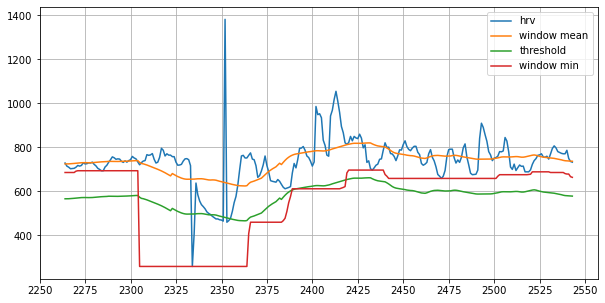

In [112]:
dataset_path = os.path.join(BASE_PATH, 'dataset')
path = os.path.join(dataset_path, 'MORF_hrv.csv')

df = read_and_preprocess(path)
threshold = 2.4*df['hrv'].std()
df = windowing(df, threshold)
graph(df)

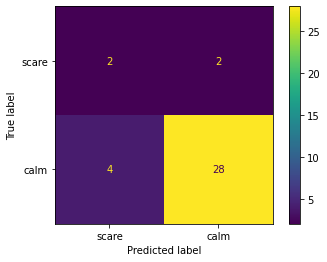

accuracy = 0.8333333333333334
precision = 0.3333333333333333
recall = 0.5
f1 = 0.3999520057593089


In [113]:
tp, fn, fp, tn = evaluate(df, [800, 930, 960, 1050, 1820])

cm = np.array(
    [
        [tp, fn],
        [fp, tn]
    ]
)

labels = ["scare", "calm"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels)
                               
disp.plot()
plt.show()

acc = (tp + tn) / (tp + fn + tn + fp)
pre = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * pre * rec) / (pre + rec + 0.0001)

print(f'accuracy = {acc}')
print(f'precision = {pre}')
print(f'recall = {rec}')
print(f'f1 = {f1}')

In [114]:
#Evaluating the model
THRESHOLD = 1.8
dataset_path = os.path.join(BASE_PATH, 'dataset')

tp_global = fn_global = fp_global = tn_global = 0

path = os.path.join(dataset_path, 'ERNESTO_hrv.csv')
df = read_and_preprocess(path)
threshold = THRESHOLD*df['hrv'].std()
df = windowing(df, threshold)
tp, fn, fp, tn = evaluate(df, [645, 740, 860, 1190, 1590])

tp_global += tp
fn_global += fn
fp_global += fp
tn_global += tn

path = os.path.join(dataset_path, 'ESTEBAN_hrv.csv')
df = read_and_preprocess(path)
threshold = THRESHOLD*df['hrv'].std()
df = windowing(df, threshold)
tp, fn, fp, tn = evaluate(df, [1650, 1710])

tp_global += tp
fn_global += fn
fp_global += fp
tn_global += tn

path = os.path.join(dataset_path, 'JOAN_hrv.csv')
df = read_and_preprocess(path)
threshold = THRESHOLD*df['hrv'].std()
df = windowing(df, threshold)
tp, fn, fp, tn = evaluate(df, [720, 1290])

tp_global += tp
fn_global += fn
fp_global += fp
tn_global += tn

path = os.path.join(dataset_path, 'MORF_hrv.csv')
df = read_and_preprocess(path)
threshold = THRESHOLD*df['hrv'].std()
df = windowing(df, threshold)
tp, fn, fp, tn = evaluate(df, [800, 930, 960, 1050, 1510])

tp_global += tp
fn_global += fn
fp_global += fp
tn_global += tn
    

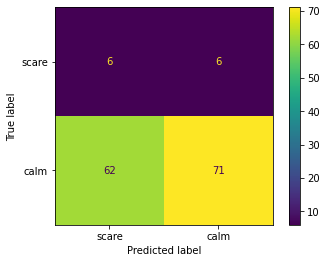

accuracy = 0.5310344827586206
precision = 0.08823529411764706
recall = 0.5
f1 = 0.14997450433426318


In [115]:
cm = np.array(
    [
        [tp_global, fn_global],
        [fp_global, tn_global]
    ]
)

labels = ["scare", "calm"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels)
                               
disp.plot()
plt.show()

acc = (tp_global + tn_global) / (tp_global + fn_global + tn_global + fp_global)
pre = tp_global / (tp_global + fp_global)
rec = tp_global / (tp_global + fn_global)
f1 = (2 * pre * rec) / (pre + rec + 0.0001)

print(f'accuracy = {acc}')
print(f'precision = {pre}')
print(f'recall = {rec}')
print(f'f1 = {f1}')